# Nicher

## Initialise Nicher

### Load packages

In [1]:
%matplotlib inline
%load_ext autoreload

import os
import sys
import gdal
import pandas as pd
import numpy as np
import xarray as xr
import datacube
import matplotlib.pyplot as plt

sys.path.append('../../../Scripts')
from dea_dask import create_local_dask_cluster
from dea_plotting import display_map, rgb

sys.path.append('../../modules')
import nicher

sys.path.append('../../shared')
import satfetcher, tools

/env/lib/python3.6/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


### Set up a dask cluster

In [2]:
# initialise the cluster. paste url into dask panel for more info.
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:41909 Dashboard: /user/lewis/proxy/8787/status,Cluster Workers: 1 Cores: 2 Memory: 13.11 GB


### Show study area for context

In [3]:
# testing study area extent - yandi and roy hill
lat_extent, lon_extent = (-22.63461, -22.33461), (119.88111, 120.18111) # royhill

# display onto interacrive map
display_map(x=lon_extent, y=lat_extent)

## Load and prepare topographic rasters

### Set raster paths

In [4]:
# get continuous rasters. we will do via arcgis eventually
folder_path = r'../../data/nicher/roy_lidar'
rast_cont_list = nicher.get_files_from_path(folder_path)

# get categorical rasters. we don't have any!
#folder_path = r'../../data/nicher/roy_srtm_cat'
#rast_cate_list = nicher.get_files_from_path(folder_path)

Found: dem_lidar_10m_solar_rad.tif
Found: dem_lidar_10m_flow_acumm.tif
Found: dem_lidar_10m_aspect.tif
Found: dem_lidar_10m.tif
Found: dem_lidar_10m_tri.tif
Found: dem_lidar_10m_valley_depth.tif
Found: dem_lidar_10m_lsfactor.tif
Found: dem_lidar_10m_convexity.tif
Found: dem_lidar_10m_saga_wetness.tif
Found: dem_lidar_10m_mrvbf.tif
Found: chm_lidar_10m.tif
Found: dem_lidar_10m_fill.tif
Found: dem_lidar_10m_mrrtf.tif
Found: dem_lidar_10m_texture.tif
Found: dem_lidar_10m_slope.tif
Found: dem_lidar_10m_tpi.tif
Found: dem_lidar_10m_curvature.tif
Found: dem_lidar_10m_topo_wetness.tif


In [5]:
# drop any undesirable vars 
rast_cont_list.remove(folder_path + '/' + 'chm_lidar_10m.tif')
rast_cont_list.remove(folder_path + '/' + 'dem_lidar_10m_fill.tif')
rast_cont_list.remove(folder_path + '/' + 'dem_lidar_10m.tif')
rast_cont_list.remove(folder_path + '/' + 'dem_lidar_10m_tri.tif')

### Load raster datasets

In [6]:
# load rasters as individual dataset variables
ds = satfetcher.load_local_rasters(rast_path_list=rast_cont_list, 
                                   use_dask=True, 
                                   conform_nodata_to=-999)

# show data
#ds

Converting rasters to an xarray dataset.
Converted raster to xarray data array: dem_lidar_10m_solar_rad
Converted raster to xarray data array: dem_lidar_10m_flow_acumm
Converted raster to xarray data array: dem_lidar_10m_aspect
Converted raster to xarray data array: dem_lidar_10m_valley_depth
Converted raster to xarray data array: dem_lidar_10m_lsfactor
Converted raster to xarray data array: dem_lidar_10m_convexity
Converted raster to xarray data array: dem_lidar_10m_saga_wetness
Converted raster to xarray data array: dem_lidar_10m_mrvbf
Converted raster to xarray data array: dem_lidar_10m_mrrtf
Converted raster to xarray data array: dem_lidar_10m_texture
Converted raster to xarray data array: dem_lidar_10m_slope
Converted raster to xarray data array: dem_lidar_10m_tpi
Converted raster to xarray data array: dem_lidar_10m_curvature
Converted raster to xarray data array: dem_lidar_10m_topo_wetness
Rasters converted to dataset successfully.



### Compute rasters into memory

In [7]:
# compute dask - we need to make calculations
ds = ds.compute()

## Load and prepare species occrruence points shapefile

### Read occurrence shapefile

In [8]:
# set path to shapefile
shp_path = r'../../data/nicher/presence_points/presence_points.shp'

# extract point x and y from shapefile as pandas dataframe
df_records = tools.read_shapefile(shp_path=shp_path)

# display result
#df_records

Reading records within shapefile.
Rows read from shapefile successfully.


### Subset columns to only x, y

In [9]:
# subset columns
df_presence = tools.subset_records(df_records=df_records, 
                                   p_a_column=None)

# drop presence column
df_presence = df_presence.drop('actual', axis='columns')

# display result
#df_presence

Subsetting records from dataframe.
Subset records successfully.


### Generate psuedo-absence points

In [10]:
# generate absences using dataset pixels and occurrence coords
df_absence = nicher.generate_absences(ds=ds, 
                                      num_abse=1000, 
                                      occur_shp_path=shp_path,
                                      buff_m=250, 
                                      res_factor=3)

# display result
#df_absence

Generating 1000 randomised psuedo-absence locations.
Generating buffer areas from occurrence points.
Generating proximity buffers around species point locations.
Proximity buffers loaded and dissolved successfully.
Randomising absence points within mask area.


/env/lib/python3.6/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


Generated pseudo-absence points successfully.


### Extract raster values to presence and absence points

In [11]:
# extract values for presence points
df_presence_data = tools.extract_xr_values(ds=ds, 
                                           coords=df_presence, 
                                           keep_xy=False, 
                                           res_factor=3)

# display result
#df_presence_data

Extracting xarray values to x and y coordinates.
Extracted xarray values successfully.


In [12]:
# do same for absence points
df_absence_data = tools.extract_xr_values(ds=ds, 
                                          coords=df_absence, 
                                          keep_xy=False, 
                                          res_factor=3)

# display result
#df_absence_data

Extracting xarray values to x and y coordinates.
Extracted xarray values successfully.


### Remove nodata values from presence and absence points

In [13]:
# remove all presence records containing nodata values
df_presence_data = tools.remove_nodata_records(df_records=df_presence_data,
                                               nodata_value=ds.nodatavals)

# display result
#df_presence_data

Removing records containing NoData (-999) values.
Removed 3774 records containing NoData values successfully.


In [14]:
# remove all absence records containing nodata values
df_absence_data = tools.remove_nodata_records(df_records=df_absence_data,
                                               nodata_value=ds.nodatavals)

# display result
#df_absence_data

Removing records containing NoData (-999) values.
Removed 0 records containing NoData values successfully.


### Equalise absence records to match presence

In [15]:
# equalise absence to match number of presence
#df_absence_data = gdvsdm.equalise_abse_records(df_presence=df_presence_data, 
                                               #df_absence=df_absence_data)

# display result
#df_absence_data

### Combine presence and absence records

In [16]:
# take pres and abse records and combine, add new pres/abse column
df_pres_abse_data = nicher.combine_pres_abse_records(df_presence=df_presence_data, 
                                                     df_absence=df_absence_data)

# display result
#df_pres_abse_data

Combining presence and pseudo-absence point locations.
Combined total of 1173 records.


## Investigate exploratory statistics

### Generate Pearson's correlation matrix

Presenting correlation matrix.


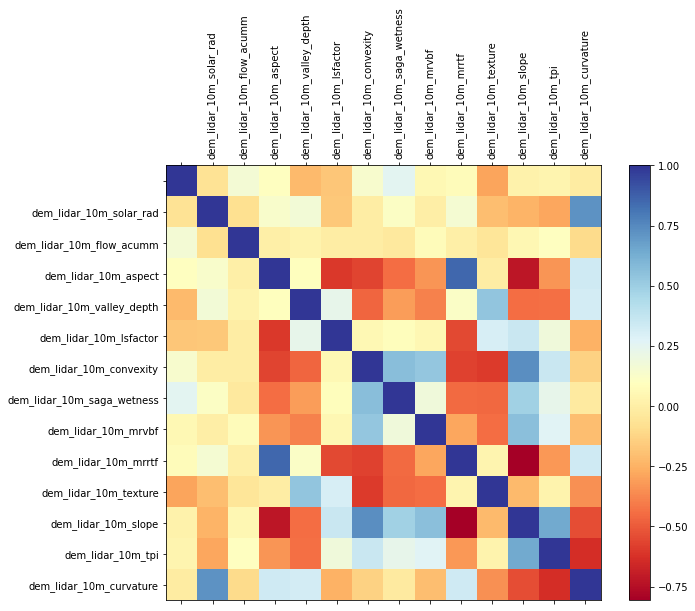

In [17]:
# generate the matrix. < 0.6 weak collinearity, 0.6-0.8 moderate, >= 0.8 strong
nicher.generate_correlation_matrix(df_records=df_pres_abse_data,
                                   show_fig=True,
                                   show_text=False)

### Generate Variance Inflation Factor (VIF) Score

In [18]:
# generate vif scores. 1 = No multicolinearity, 1-5 = moderate, > 5 = high, > 10 = Remove
nicher.generate_vif_scores(df_records=df_pres_abse_data)

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
                      Variable  VIF Score
2         dem_lidar_10m_aspect      1.047
0      dem_lidar_10m_solar_rad      1.225
8          dem_lidar_10m_mrrtf      1.497
7          dem_lidar_10m_mrvbf      1.707
5      dem_lidar_10m_convexity      1.879
12     dem_lidar_10m_curvature      2.153
4       dem_lidar_10m_lsfactor      2.247
13  dem_lidar_10m_topo_wetness      2.536
3   dem_lidar_10m_valley_depth      2.774
1     dem_lidar_10m_flow_acumm      3.144
6   dem_lidar_10m_saga_wetness      3.572
9        dem_lidar_10m_texture      4.082
10         dem_lidar_10m_slope      4.613
11           dem_lidar_10m_tpi      5.335
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



## Perform Species Distribution Modelling 

### Create estimator

In [19]:
# create a random forest estimator using default sklearn parameters
estimator = nicher.create_estimator(estimator_type='rf', 
                                    n_estimators=100)

Creating species distribution model estimator.
Setting up estimator for Random Forest.
Estimator created successfully.


### Generate SDM

Beginning species distribution modelling (SDM) process.
Generating SDM replicate: 1 of 5.
Generating SDM replicate: 2 of 5.
Generating SDM replicate: 3 of 5.
Generating SDM replicate: 4 of 5.
Generating SDM replicate: 5 of 5.
SDM processing completed. Getting outputs in order.
Preparing accuracy information.
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
                      Variable  Mean Importance Score
7          dem_lidar_10m_mrvbf               0.150326
6   dem_lidar_10m_saga_wetness               0.097291
5      dem_lidar_10m_convexity               0.087828
3   dem_lidar_10m_valley_depth               0.084423
12     dem_lidar_10m_curvature               0.080261
1     dem_lidar_10m_flow_acumm               0.079486
13  dem_lidar_10m_topo_wetness               0.078510
11           dem_lidar_10m_tpi               0.070971
10         dem_lidar_10m_slope               0.055054
8          dem_lidar_10m_mrrtf               0.053792
4       dem_lidar_10m_lsfactor     

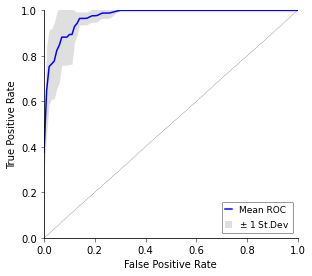

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Training Out-Of-Bag (OOB) Accuracy:		1.0
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

- - Probabilities Accuracy Metrics  - - - - - - - - - - - - 
Area Under the ROC Curve (AUC).
Terrible = 0.5 | Moderate = 0.75 | Perfect = 1.0
AUC: 0.971

Area Under the Precision Recall Curve (PR Score).
Terrible = 0.0 | Perfect = 1.0.
PR Score: 0.861

Brier Loss Score.
Terrible: 1.0 | Perfect: 0.0 (lower score is better).
Brier Loss Score: 0.047

Log-Loss Score (stricter than Brier Loss Score).
Perfect: 0.0 (lower score is better).
Log-Loss Score: 0.156

Point-biserial Correlation Coefficient (R-value).
Perfect + relationship = 1 | Perfect - relationship = -1 | No relationship = 0. 
R-value: 0.79
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

- - Classification Accuracy Metrics - - - - - - - - - - - - 
Proportion of presence records: 0.008
Proporti

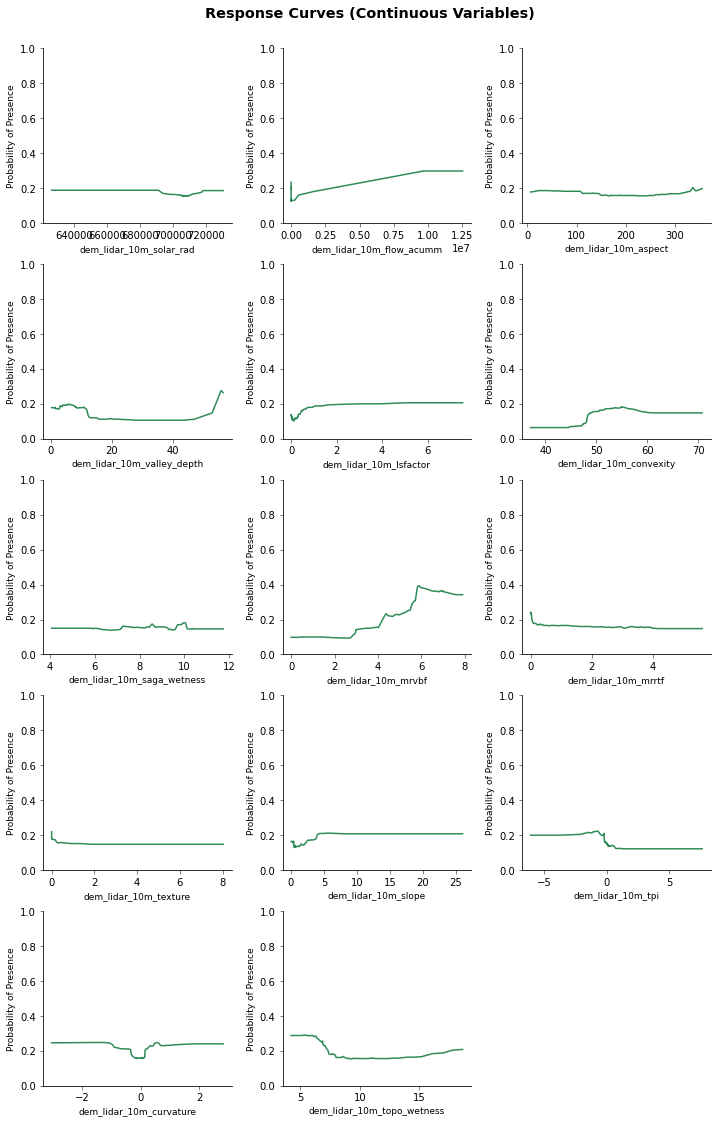

In [20]:
# generate SDM with 5 replicates and 10% training-testing split
ds_sdm = nicher.generate_sdm(ds=ds, 
                             df_records=df_pres_abse_data, 
                             estimator=estimator, 
                             rast_cont_list=rast_cont_list, 
                             rast_cate_list=None, 
                             replicates=5, 
                             test_ratio=0.1, 
                             equalise_test_set=False, 
                             calc_accuracy_stats=True)

### Display SDM result

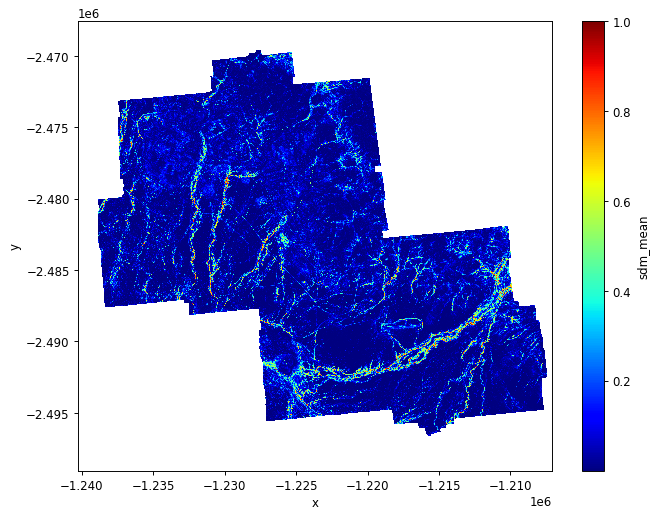

In [21]:
# set the sdm variable to display (i.e. sdm_mean, sdm_stdv, sdm_cvar)
metric_name = 'sdm_mean'

# create fig
fig = plt.figure(figsize=(9, 7), dpi=85)

# plot this on map
ds_sdm[metric_name].plot(robust=False, cmap='jet')